In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from catboost import *
%matplotlib inline

In [3]:
data = pd.read_csv('train.csv')
data.head()

,id,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,target
0,0,2,908749,954,480270,935,71,79,53,89,...,51,100,87,3,61,48,43,79,329,0
1,1,1,438444,2162,486685,2154,32,39,48,49,...,39,83,91,6,57,94,15,89,581,1
2,2,1,596915,2066,711059,2081,43,21,58,94,...,7,52,37,50,69,60,89,10,548,0
3,3,1,625198,1508,66810,1474,7,1,34,73,...,39,27,55,97,83,1,88,87,555,1
4,4,2,228654,1202,542816,1196,53,35,16,80,...,35,95,50,55,10,49,12,68,651,0


Разделим выборку на обучение и валидацию, в попытках избежать переобучение.

In [4]:
y = data.target
X = data.drop(['target', 'id'], axis=1)

In [6]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)

## В Лоб

Попробуем решить задачу в лоб, с помощью логистической регрессии. Будем брать данные как они есть и работать с ними как с числовыми. Предварительно только отнормируем их.

In [7]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=241)

Константу регуляризации подберем перебором.

In [9]:
def scorer_logreg(X, y):
    scores = {}

    for i in range(-3, 3):
        C = 10.0 ** i

        print(f"C={C}")
        model = LogisticRegression(C=C, random_state=241)

        score = cross_val_score(model, X, y, cv=cv, scoring="neg_log_loss", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        
        scores[i] = score
        print()

    return pd.Series(scores)

C=0.001
Score: -0.664

C=0.01
Score: -0.664

C=0.1
Score: -0.664

C=1.0
Score: -0.664

C=10.0
Score: -0.664

C=100.0
Score: -0.664



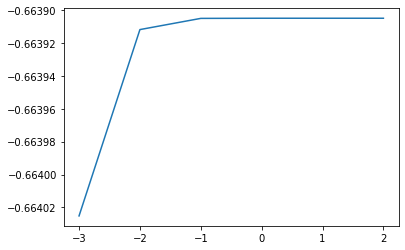

In [10]:
scores = scorer_logreg(X_train, y_train)
plt.plot(scores)

Как видно, константа регуляризации повлияла незначительно на качество решения.

## Data Engineering

Попробуем поработать с признаками. Нагенерировать новых и определить какие признаки наиболее значимы. Можно было бы попробовать применить различные кодирования, например, one-Hot или Lable Encoding или просто захешировать их, то это значительно увеличит датасет, а как показывает практика к улучшению результат не приведет (пробовал)

In [11]:
def hash_(x):
    hash_space = 50
    return list(map(lambda y: hash(y) % hash_space, x))

Предположим, что id юнитов как-то связаны с численностью юнита и будем работать с этим признаком как с числовым для генерации новых фичей.

In [12]:
def data_prepairing(X):
    army_count_1 = X['X5'] + X['X7'] + X['X9'] + X['X11'] + X['X13'] + X['X15'] + X['X17'] + X['X19'] # размер войска первого игрока
    army_count_2 = X['X6'] + X['X8'] + X['X10'] + X['X12'] + X['X14'] + X['X16'] + X['X18'] + X['X20'] # размер войска второго игрока
    
    X['army_relation'] = list(map(lambda x: 1 if x > 1 else 0, army_count_1/army_count_2)) # отношение размеров армиий
    X['army_diff'] = hash_(army_count_1 - army_count_2) # разница численности войск
    X['army_1'] = army_count_1
    X['army_2'] = army_count_2
    X['rank1_time'] = hash_(X['X2'] * X['X21']) # рейтинг игрока 1 и время игры
    X['rank2_time'] = hash_(X['X4'] * X['X21']) # рейтинг игрока 1 и время игры
    X['type_time'] = hash_(X['X0'] * X['X21']) # тип игрока 1 и время игры
    X['pers1_time'] = hash_(X['X1'] * X['X21']) # id игрока 1 и время игры
    X['pers2_time'] = hash_(X['X3'] * X['X21']) # id игрока 1 и время игры
    X['rank_relation'] = list(map(lambda x: 1 if x > 1 else 0, X['X2']/(X['X4']))) # отношение рейтингков игроков
    X['rank_diff'] = hash_(X['X2'] - X['X4']) # разность рейтингов игроков
    
    return X

In [13]:
X = data_prepairing(X)

In [14]:
X.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,army_diff,army_1,army_2,rank1_time,rank2_time,type_time,pers1_time,pers2_time,rank_relation,rank_diff
0,2,908749,954,480270,935,71,79,53,89,15,...,27,456,479,16,15,8,21,30,1,19
1,1,438444,2162,486685,2154,32,39,48,49,100,...,35,439,404,22,24,31,14,35,1,8
2,1,596915,2066,711059,2081,43,21,58,94,88,...,16,407,441,18,38,48,20,32,0,35
3,1,625198,1508,66810,1474,7,1,34,73,6,...,19,332,413,40,20,5,40,0,1,34
4,2,228654,1202,542816,1196,53,35,16,80,72,...,36,291,505,2,46,2,4,16,1,6


In [15]:
X.keys()

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'army_relation', 'army_diff', 'army_1', 'army_2', 'rank1_time',
       'rank2_time', 'type_time', 'pers1_time', 'pers2_time', 'rank_relation',
       'rank_diff'],
      dtype='object')

Нагенерировали кучу признаков, теперь посмотрим какие из них действительно важные. Для этого воспользуемся подходом Recursive feature elimination with cross-validation а в качестве классификатора возьмем случайный лес

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

clf = RandomForestClassifier(n_estimators=20, n_jobs=-1, max_depth=5)

trans = RFECV(clf, scoring=log_loss)
X_trans = trans.fit_transform(X, y)

In [48]:
X.loc[:, trans.get_support()].head()

,X2,X6,X11,X19,rank_relation,rank_diff
0,954,79,75,43,1,19
1,2162,39,57,15,1,8
2,2066,21,16,89,0,35
3,1508,1,20,88,1,34
4,1202,35,43,12,1,6


Судя по RFECV, наиболее значимые признаки для модели: 'X2', 'X6', 'X11', 'X19', 'rank_relation', 'rank_diff'

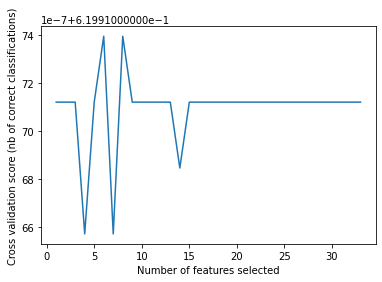

In [36]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(trans.grid_scores_) + 1),
         trans.grid_scores_)
plt.show()

In [16]:
selected_features = ['X2', 'X6', 'X11', 'X19', 'rank_relation', 'rank_diff']

In [17]:
X_selected = X.loc[:, selected_features]

X_train, X_validation, y_train, y_validation = train_test_split(X_selected, y, train_size=0.8, random_state=42, shuffle=True)
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

C=1e-05
Score: -0.664

C=0.0001
Score: -0.664

C=0.001
Score: -0.664

C=0.01
Score: -0.664

C=0.1
Score: -0.664

C=1.0
Score: -0.664

C=10.0
Score: -0.664

C=100.0
Score: -0.664

C=1000.0
Score: -0.664

C=10000.0
Score: -0.664

C=100000.0
Score: -0.664



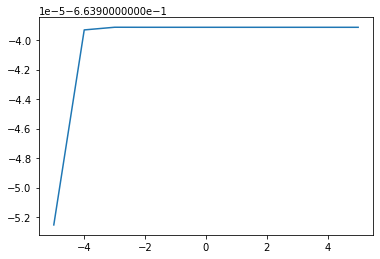

In [73]:
scores = scorer_logreg(X_train, y_train)
plt.plot(scores)

как видно картина изменилась не сильно, хотя теперь наша выборка стала меньше и обучаться модель может быстрее. Попробуем добавить к признакам еще тип игры 'X0', но применим к нему one hot encoding 

In [80]:
X_0 = pd.get_dummies(X['X0'], prefix='X0')

X_selected = pd.concat([X_selected, X_0], axis=1)
X_selected.head()

,X2,X6,X11,X19,rank_relation,rank_diff,X0_1,X0_2,X0_3,X0_4,X0_5,X0_6,X0_8
0,954,79,75,43,1,19,0,1,0,0,0,0,0
1,2162,39,57,15,1,8,1,0,0,0,0,0,0
2,2066,21,16,89,0,35,1,0,0,0,0,0,0
3,1508,1,20,88,1,34,1,0,0,0,0,0,0
4,1202,35,43,12,1,6,0,1,0,0,0,0,0


In [81]:
X_train, X_validation, y_train, y_validation = train_test_split(X_selected, y, train_size=0.8, random_state=42, shuffle=True)
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

C=1e-05
Score: -0.664

C=0.0001
Score: -0.664

C=0.001
Score: -0.664

C=0.01
Score: -0.664

C=0.1
Score: -0.664

C=1.0
Score: -0.664

C=10.0
Score: -0.664

C=100.0
Score: -0.664

C=1000.0
Score: -0.664

C=10000.0
Score: -0.664

C=100000.0
Score: -0.664



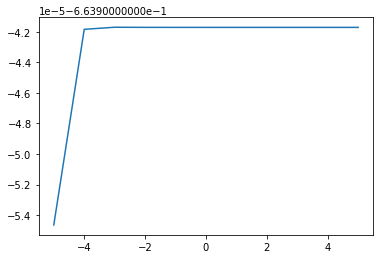

In [82]:
scores = scorer_logreg(X_train, y_train)
plt.plot(scores)

Кажется и это погоды не сделало. Попробуем перейти к более сложной модели.

# CatBoost

In [85]:
X_train, X_validation, y_train, y_validation = train_test_split(X_selected.loc[:, 'X2':'rank_diff'], y, train_size=0.8,
                                                                random_state=42, shuffle=True)

In [86]:
cat_features = list(range(0, X_train.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5]


In [87]:
# !rm 'catboost_info/snapshot.bkp'
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    verbose=10,
    random_seed=42,
    learning_rate=0.7,
    # save_snapshot=True,
    # snapshot_file='snapshot.bkp',
    # snapshot_interval=1,
    # l2_leaf_reg=2.0,
    early_stopping_rounds=20,
    # one_hot_max_size=2,
    # bootstrap_type='Bernoulli',
    # subsample=0.5,
    # random_strength=2,
    use_best_model=True,
    best_model_min_trees=30,
    # rsm=0.5,
    # leaf_estimation_iterations=5
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    plot=False
)

0:	learn: 0.6665691	test: 0.6662606	best: 0.6662606 (0)	total: 704ms	remaining: 11m 43s
10:	learn: 0.6632284	test: 0.6626057	best: 0.6626057 (10)	total: 14.3s	remaining: 21m 28s
20:	learn: 0.6631602	test: 0.6625761	best: 0.6625760 (19)	total: 24.3s	remaining: 18m 53s
30:	learn: 0.6630750	test: 0.6625662	best: 0.6625659 (29)	total: 32.8s	remaining: 17m 6s
40:	learn: 0.6629851	test: 0.6625541	best: 0.6625521 (39)	total: 40.9s	remaining: 15m 57s
50:	learn: 0.6628956	test: 0.6625552	best: 0.6625521 (39)	total: 49.6s	remaining: 15m 22s
60:	learn: 0.6628122	test: 0.6625479	best: 0.6625374 (55)	total: 57.2s	remaining: 14m 40s
70:	learn: 0.6627213	test: 0.6625520	best: 0.6625374 (55)	total: 1m 5s	remaining: 14m 21s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6625374465
bestIteration = 55

Shrink model to first 56 iterations.


Качество стало лучше, попробуем настроить параметры модели.

Feature Importance для нашей модели.

In [89]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,X19,23.078232
1,X6,20.163040
2,X11,20.057430
3,rank_relation,15.923471
4,X2,12.880414
5,rank_diff,7.897412


# Hyperparameter tunning

In [94]:
from sklearn.model_selection import GridSearchCV

In [103]:
param_grid = {'l2_leaf_reg': [1, 3, 5],
              'rsm': [0.1, 0.5, 0.7],
             'learning_rate': [0.3, 0.8, 1.5]}
base_estimator = CatBoostClassifier(
    verbose=False,
    n_estimators = 150,
    random_seed=42,
    early_stopping_rounds=20,
    bootstrap_type='Bernoulli',
    best_model_min_trees=30,
    cat_features=cat_features
    )

clf = GridSearchCV(base_estimator, param_grid)
clf.fit(X_train, y_train)

sorted(clf.cv_results_.keys())

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

KeyboardInterrupt: 

## Попробуем запустить нейронку, почему бы и нет

In [19]:
import torch

ModuleNotFoundError: No module named 'torch'

In [ ]:
X_nn = pd.DataFrame(scaler.fit_transform(X_selected), index=X_selected.index, columns=X_selected.columns)
y_nn = copy(y)

In [ ]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length
trainset = dataset(X_nn,y_nn)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

In [ ]:
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,1)
        
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [ ]:
#hyper parameters
learning_rate = 0.01
epochs = 700
# Model , Optimizer, Loss
model = Net(input_shape=x.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [ ]:
#forward loop
losses = []
accur = []
for i in range(epochs):
    for j,(x_train,y_train) in enumerate(trainloader):
    
        #calculate output
        output = model(x_train)

        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))

        #accuracy
        predicted = model(torch.tensor(x,dtype=torch.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == y).mean()
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i%50 == 0:
        losses.append(loss)
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

In [ ]:
#plotting the loss
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

# Saving Model

# Calculate predictions for the contest

In [76]:
data_test = pd.read_csv('test.csv')
data_test.head()

,id,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21
0,0,1,1032217,1187,1011523,1172,57,100,1,80,...,79,45,18,35,10,80,81,16,0,547
1,1,2,1059033,2128,505263,2104,82,27,87,79,...,74,96,55,54,48,3,92,5,51,656
2,2,1,207787,1017,822639,1040,82,48,43,62,...,16,64,35,70,99,60,30,37,45,437
3,3,1,1095582,1449,32841,1424,71,43,11,98,...,1,7,41,94,26,52,45,81,1,589
4,4,2,963764,1202,489871,1182,11,62,16,55,...,26,60,37,7,1,80,48,50,52,340


In [77]:
X_test = data_test.drop(['id'], axis=1)
X_test.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21
0,1,1032217,1187,1011523,1172,57,100,1,80,25,...,79,45,18,35,10,80,81,16,0,547
1,2,1059033,2128,505263,2104,82,27,87,79,80,...,74,96,55,54,48,3,92,5,51,656
2,1,207787,1017,822639,1040,82,48,43,62,18,...,16,64,35,70,99,60,30,37,45,437
3,1,1095582,1449,32841,1424,71,43,11,98,80,...,1,7,41,94,26,52,45,81,1,589
4,2,963764,1202,489871,1182,11,62,16,55,88,...,26,60,37,7,1,80,48,50,52,340


In [78]:
test_army_count_1 = X_test['X5'] + X_test['X7'] + X_test['X9'] + X_test['X11'] + X_test['X13'] + X_test['X15'] + X_test['X17'] + X_test['X19']
test_army_count_2 = X_test['X6'] + X_test['X8'] + X_test['X10'] + X_test['X12'] + X_test['X14'] + X_test['X16'] + X_test['X18'] + X_test['X20']
X_test['army_relation'] = list(map(lambda x: 1 if x > 1 else 0, test_army_count_1/test_army_count_2))

X_test['army_1'] = test_army_count_1
X_test['army_2'] = test_army_count_2
X_test['type_time'] = X_test['X0'] * X_test['X21']
X_test['pers1_time'] = X_test['X1'] * X_test['X21']
X_test['pers2_time'] = X_test['X3'] * X_test['X21']

X_test['rank_relation'] = list(map(lambda x: 1 if x > 1 else 0, X_test['X2']/(X_test['X4'])))

In [79]:
y_test = model.predict_proba(X_test)
y_test = y_test[:, 1]

# Prepare the submission

In [80]:
ans = pd.DataFrame(data=y_test, columns=["target"])
ans.reset_index(level=0, inplace=True)
ans.reset_index(drop=True, inplace=True)
ans = ans.rename(columns={'index':'id'})
ans.head()

,id,target
0,0,0.375669
1,1,0.351177
2,2,0.309032
3,3,0.340965
4,4,0.333700


In [81]:
ans.to_csv('submission.csv',index=False)